In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Conv3D, MaxPool3D, BatchNormalization, Dropout, Flatten, Dense, Activation
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [2]:
!git clone https://github.com/Yuvnish017/Dynamic_Hand_Gesture_Recognition.git

Cloning into 'Dynamic_Hand_Gesture_Recognition'...
remote: Enumerating objects: 2489, done.
remote: Counting objects: 100% (2489/2489), done.
remote: Compressing objects: 100% (2461/2461), done.
remote: Total 2489 (delta 27), reused 2488 (delta 26), pack-reused 0
Receiving objects: 100% (2489/2489), 5.17 MiB | 2.56 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [2]:
X = []
Y = []

d = {'ClosingFist':0,
     'LeftSwipe':1,
     'OpeningFist':2,
     'RightSwipe':3}

datadir = 'Dynamic_Hand_Gesture_Recognition/dataset'
for classes in os.listdir(datadir):
  path = os.path.join(datadir, classes)
  for folder in os.listdir(path):
    m = np.zeros(shape=(30, 128, 128, 1))
    imgs = os.path.join(path, folder)
    for i, img in enumerate(os.listdir(imgs)):
      image = cv2.imread(os.path.join(imgs, img))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image = np.array(image)
      image = np.expand_dims(image, axis=-1)
      image = image/255.
      m[i, :, :, :] = image
    X.append(m)
    Y.append(d[classes])

print(len(X))
print(len(Y))

80
80


In [3]:
X = X*10
Y = Y*10

In [4]:
print(len(X))
print(len(Y))

800
800


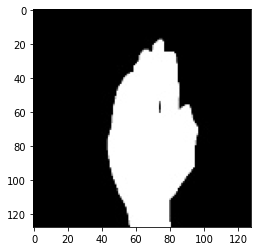

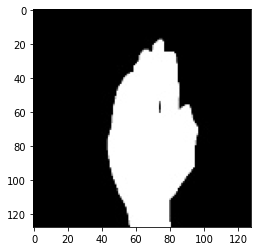

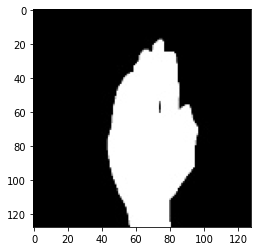

In [5]:
plt.imshow(np.squeeze(X[0][0], axis=-1), cmap='gray')
plt.show()

plt.imshow(np.squeeze(X[80][0], axis=-1), cmap='gray')
plt.show()

plt.imshow(np.squeeze(X[160][0], axis=-1), cmap='gray')
plt.show()

In [6]:
X = np.array(X)
Y = np.array(Y)

# encoder = LabelEncoder()
# Y = encoder.fit_transform(encoder)
# X = np.expand_dims(X, axis=-1)

Y = to_categorical(Y)

print(X.shape)
print(Y.shape)

(800, 30, 128, 128, 1)
(800, 4)


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


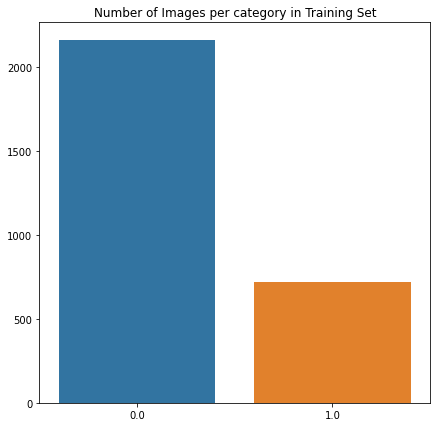

In [ ]:
unique_train, count_train = np.unique(Y_train, return_counts=True)
figure = plt.figure(figsize=(7, 7))
sns.barplot(unique_train, count_train).set_title('Number of Images per category in Training Set')
plt.show()

In [ ]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
figure = plt.figure(figsize=(7, 7))
sns.barplot(unique_test, count_test).set_title('Number of Images per category in Test Set')
plt.show()

In [9]:
model = Sequential()
model.add(Input(shape=(30, 128, 128, 1)))
model.add(Conv3D(16, (5, 5, 5), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0), name='conv1'))
model.add(MaxPool3D((2, 2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Conv3D(32, (5, 5, 5), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0), name='conv2'))
model.add(MaxPool3D((2, 2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Conv3D(64, (5, 5, 5), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0), name='conv3'))
model.add(MaxPool3D((2, 2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))

opt = Adam()

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv3D)              (None, 30, 128, 128, 16)  2016      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 15, 64, 64, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 15, 64, 64, 16)   64        
 hNormalization)                                                 
                                                                 
 conv2 (Conv3D)              (None, 15, 64, 64, 32)    64032     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 32, 32, 32)    0         
 3D)                                                             
                                                      

In [10]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/hand_gesture_recognition_v1.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='min')
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

# callbacks = [checkpoint, LR]
callbacks = [checkpoint, LearningRateScheduler(step_decay)]

hist = model.fit(X_train, Y_train, batch_size=32, epochs=20, validation_data=(X_test, Y_test), callbacks=callbacks)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 0.7630 - accuracy: 0.7181
Epoch 00001: val_loss improved from inf to 1.65932, saving model to /content/drive/MyDrive/hand_gesture_recognition_v1.h5
23/23 [==============================] - 59s 2s/step - loss: 0.7630 - accuracy: 0.7181 - val_loss: 1.6593 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.9292
Epoch 00002: val_loss improved from 1.65932 to 1.43551, saving model to /content/drive/MyDrive/hand_gesture_recognition_v1.h5
23/23 [==============================] - 38s 2s/step - loss: 0.2246 - accuracy: 0.9292 - val_loss: 1.4355 - val_accuracy: 0.6625 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.1152 - accuracy: 0.9694
Epoch 00003: val_loss did not improve from 1.43551
23/23 [==============================] - 37s 2s/step - loss: 0.1152 - accuracy: 0.9694 - val_loss: 3.7514 - val_accuracy: 0.6125 - lr: 

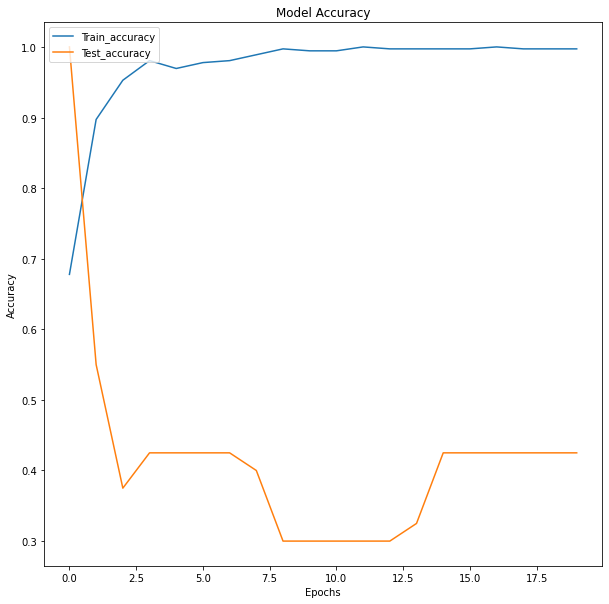

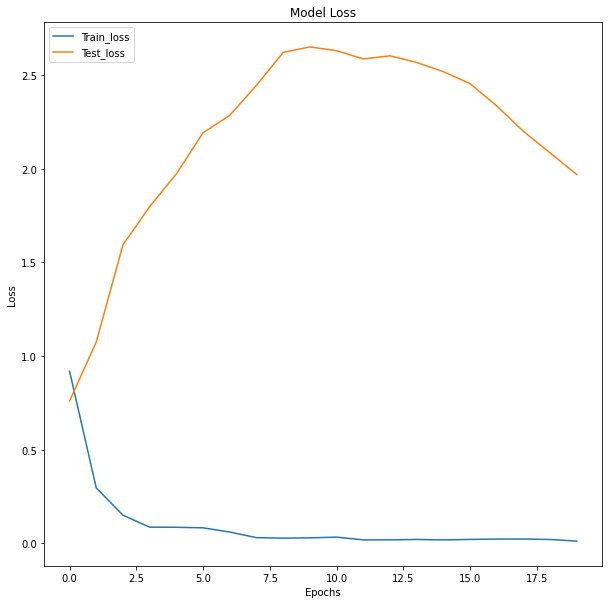

In [ ]:
figure1 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [ ]:
y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis=1)
Y_test_copy = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_copy, y_pred_test))

              precision    recall  f1-score   support

           0       0.25      1.00      0.40         6
           1       0.00      0.00      0.00        10
           2       0.69      1.00      0.81        11
           3       0.00      0.00      0.00        13

    accuracy                           0.42        40
   macro avg       0.23      0.50      0.30        40
weighted avg       0.23      0.42      0.28        40



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


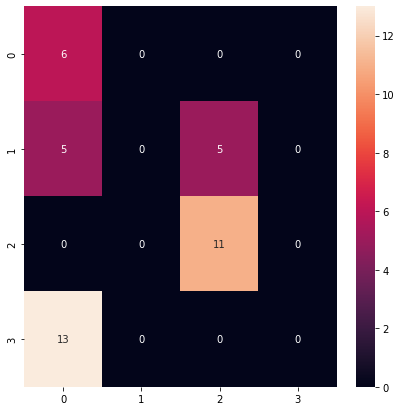

In [ ]:
matrix = confusion_matrix(Y_test_copy, y_pred_test)
figure = plt.figure(figsize=(7, 7))
df = pd.DataFrame(matrix, index=[0, 1, 2, 3], columns=[0, 1, 2, 3])
sns.heatmap(df, annot=True, fmt='d')
plt.show()

In [ ]:
def batch_generator(t, batch_number, batch_size):
  d = {''}
  batch_data = np.zeros(shape=(batch_size, 30, 128, 128, 1))
  batch_label = np.zeros(shape=(batch_size, 8))
  for folder in range(batch_size):
    imgs = os.listdir('dataset/' + t[folder + (batch_number*batch_size)])
    for i, img in enumerate(imgs):
      image = cv2.imread(os.path.join('dataset/' + t[folder + (batch_number*batch_size)], img))
      image = image/255.
      batch_data[folder, i, :, :, :] = image
    batch_label[folder, d[t[folder + (batch_number*batch_size)].split('_')[0]]] = 1

In [ ]:
def generator(folder_list, batch_size):
  while True:
    t = folder_list
    num_batches = int(len(folder_list)/batch_size)
    for batch in range(num_batches):
      yield batch_generator(t, batch, batch_size)

    if len(folder_list)%batch_size == 0:
      batch_size = len(folder_list)%batch_size
      yield batch_generator(t, batch, batch_size) 

In [ ]:
folder_names = os.listdir('dataset')
folder_names = np.random.permutation(folder_names)

train_folders = folder_names[:0.8*len(folder_names)]
test_folders = folder_names[0.8*len(folder_names):]

train_generator = generator(train_folders, 32)
test_generator = generator(test_folders, 32)

number_of_train_sequences = 0.8*len(folder_names)
number_of_test_sequences = 0.2*len(folder_names)

if (number_of_train_sequences%32) == 0:
    steps_per_epoch = int(number_of_train_sequences/32)
else:
    steps_per_epoch = (number_of_train_sequences//32) + 1

if (number_of_test_sequences%32) == 0:
    validation_steps = int(number_of_test_sequences/32)
else:
    validation_steps = (number_of_test_sequences//32) + 1

In [ ]:
model = Sequential()
model.add(Input(shape=(30, 128, 128, 1)))
model.add(Conv3D(16, (5, 5, 5), activation='relu', kernel_initializer=glorot_uniform(seed=0), name='conv1'))
model.add(MaxPool3D((2, 2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=glorot_uniform(seed=0), name='conv2'))
model.add(MaxPool3D((2, 2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=glorot_uniform(seed=0), name='conv3'))
model.add(MaxPool3D((2, 2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))

opt = Adam()

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/hand_gesture_recognition_v1.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='min')
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

callbacks = [checkpoint, LR]
# callbacks = [checkpoint, LearningRateScheduler(step_decay)]

hist = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, 
                           epochs=num_epochs, verbose=1, callbacks=callbacks,
                           validation_data=val_generator, 
                           validation_steps=validation_steps,
                           class_weight=None, workers=1, initial_epoch=0)

In [ ]:
figure1 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()